In [26]:
# Populating the interactive namespace from numpy, matplotlib, math, scipy, clawpack.geoclaw, pymap3d
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy import interpolate
from clawpack.geoclaw import fgmax_tools, geoplot #import fgmax_tools
from pymap3d import geodetic2ned as g2ned

In [25]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) using haversine 
    formula. As an input receives coordinates of the two points
    (the longitude  and the latitude of the first point and the 
    longitude and the latitude of the second point, respectfully)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # radius of earth in kilometers is 6371
    dist = 6371000* c
    return dist

In [27]:
def find_inundation(runup_lon, runup_lat, coast_lon, coast_lat):
     """
    Calculate the inundation by finding the shortest distance to the coastline 
    which is done by checking distances from the point 
    at the given water elevation level to each point on the coastline and the 
    distances to the segments of the coastline closest to the point.
    As an input receives vectors of coordinates of the given water elevation level
    (longitude and latitude, respectfully) and the coastline (longitude and latitude).
    """
    inundation = np.zeros(len(runup_lon))
    len_runup = len(runup_lon)
    len_coast = len(coast_lon)
    # for each point on the given water elevation level
    for i in range(len_runup):
        ddist = 100000*np.ones(2*len_coast)
        # checking each point on the coastline
        for j in range(len_coast):
            # calculating great circle distance between two points
            ddist[j] = haversine(runup_lon[i], runup_lat[i], coast_lon[j], coast_lat[j])
            # checking a position of the segment relative to the point by calculating two angles
            if j != (len_coast - 1):
                # calculating cartesian coordinates of the current and the next points on the coastline
                # relative to the current point at the given water elevetaion level
                l1 = g2ned(coast_lat[j], coast_lon[j], 0, runup_lat[i], runup_lon[i], 0, ell=None, deg=True)
                l2 = g2ned(coast_lat[j + 1], coast_lon[j + 1], 0, runup_lat[i], runup_lon[i], 0, ell=None, deg=True)
                l1 = np.array(l1)
                l2 = np.array(l2)
                # calculating the first angle
                lenx1 = np.linalg.norm(l1) 
                lenx2x1 = np.linalg.norm(l2 - l1)
                theta1 = acos(np.dot(l1, l2 - l1)/lenx1/lenx2x1)
                if theta1 < pi/2:
                    # if the first angle is less than 90, calculating the second angle
                    theta2 = asin(lenx1*sin(theta1)/np.linalg.norm(l2))
                    if theta2 < pi/2:
                        # if also the second angle is less than 90, calculating the shortest distance to the line
                        # defined by the two points on the coastline
                        ddist[j + len_coast] = np.linalg.norm(np.cross(l2-l1, l1))/lenx2x1
        inundation[i] = np.nanmin(ddist)
    return inundation

In [59]:
def runup_inundation(crd):
    """
    Calculate the runup and the inundation for given area
    (crd = [min(longitude), max(longitude), min(latitude), max(latitude)] )
    """
    # reading the GeoClaw output
    fg = fgmax_tools.FGmaxGrid()
    fg.read_input_data("fgmax_grid.txt")
    fg.read_output(outdir="_output")
    # calculating surface elevation in ocean
    zeta = np.where(fg.B>0, fg.h, fg.h+fg.B)  
    # calculating indices for the given area
    idx = [idx for idx in range(len(fg.X)) if fg.X[idx,1] >= crd[0] and fg.X[idx,1] <= crd[1]]
    idy = [idy for idy in range(len(fg.X[1,:])) if fg.Y[1,idy] >= crd[2] and fg.Y[1,idy] <= crd[3]]
    x1 = min(idx)
    x2 = max(idx) + 1
    y1 = min(idy)
    y2 = max(idy) + 1
    # calculating the coastline and the line of zero (or close to zero) water elevation
    b0 = plt.contour(fg.X[x1:x2, y1:y2],fg.Y[x1:x2, y1:y2],fg.B[x1:x2, y1:y2], levels=[0]); plt.clf()  # coastline
    h0 = plt.contour(fg.X[x1:x2, y1:y2],fg.Y[x1:x2, y1:y2],zeta[x1:x2, y1:y2], levels=[0.001]); plt.clf()
    xy_runup = h0.collections[0].get_paths()[0].vertices
    xy_coast = b0.collections[0].get_paths()[0].vertices
    # calculating the runup by interpolating the bathimetry on the line of zero water elevation
    runup = interpolate.griddata((fg.X[x1:x2, y1:y2].flatten(), fg.Y[x1:x2, y1:y2].flatten()), fg.B[x1:x2, y1:y2].flatten(), xy_runup, "cubic")
    # calculating the inundation
    inundation = find_inundation(xy_runup[:,0], xy_runup[:,1], xy_coast[:,0], xy_coast[:,1])
    return runup, inundation, xy_runup

In [60]:
[runup, inundation, xy_runup] = runup_inundation([33.4, 35.5, 30.7, 33.8])

Reading _output/fort.FG1.valuemax ...
Reading _output/fort.FG1.aux1 ...


In [61]:
inundation

array([ 2256.57471205,  1204.43545796,  5500.70261727,     7.48911995,
        1599.55729795,  2337.38217403,   815.0249948 ,  2355.38755957,
         645.86386495,   265.16323118,  1261.64619428,   618.2627674 ,
        2239.46084533,  1915.01398396,  1077.2608209 ,   428.30835281,
         712.84671552,  1514.21240179,  1036.41637977,  3665.31860766,
        3355.6492353 ,   780.47787673,   392.56487715,  1050.3684879 ,
        3876.78922719,   868.23229789,  1551.33795639,  5103.9008256 ])

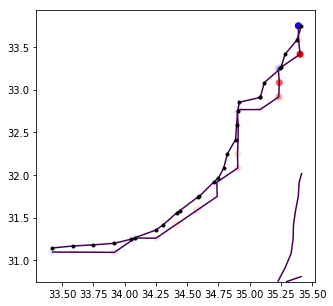

In [38]:
plt.figure(figsize=(5, 5))
b0 = plt.contour(fg.X[x1:x2, y1:y2],fg.Y[x1:x2, y1:y2],fg.B[x1:x2, y1:y2], levels=[0])  # coastline
h0 = plt.contour(fg.X[x1:x2, y1:y2],fg.Y[x1:x2, y1:y2],zeta[x1:x2, y1:y2], levels=[0.001])
plt.scatter(xy_runup[:, 0], xy_runup[:, 1], c=runup, cmap="bwr")
plt.plot(xy_coast[:, 0], xy_coast[:, 1], 'k.')

In [62]:
runup

array([-275.33339993,   57.51064131,  329.17416218,   -2.56043636,
        -35.23119966,  229.62606747,  141.60367348,   47.05430154,
         58.10788463,    5.38648789,   47.99609292,   21.59846163,
         61.38809617,   77.73886264,    9.79963215,    5.46043014,
         36.92564854,   60.78610233,   64.09092188,   60.45820125,
         57.40375792,   53.2275138 ,    0.33156706,    2.58366879,
         56.75904206,   36.22966426,   17.28773212,    4.18404113])